In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Analyse de personnalité client - Modélisation

Ce notebook réalise l'analyse non supervisée du jeu de données issu de la **Customer Personality Analysis** disponible sur Kaggle.
Nous allons:
1. Charger et explorer les données
2. Nettoyer et prétraiter le jeu de données
3. Réduire la dimension avec une sélection de variables et une analyse factorielle
4. Appliquer trois méthodes de clustering (k-means, CAH, DBSCAN)
5. Comparer les résultats et profiler les groupes obtenus
6. Conclure

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('../data/marketing_campaign.csv', sep='	')
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


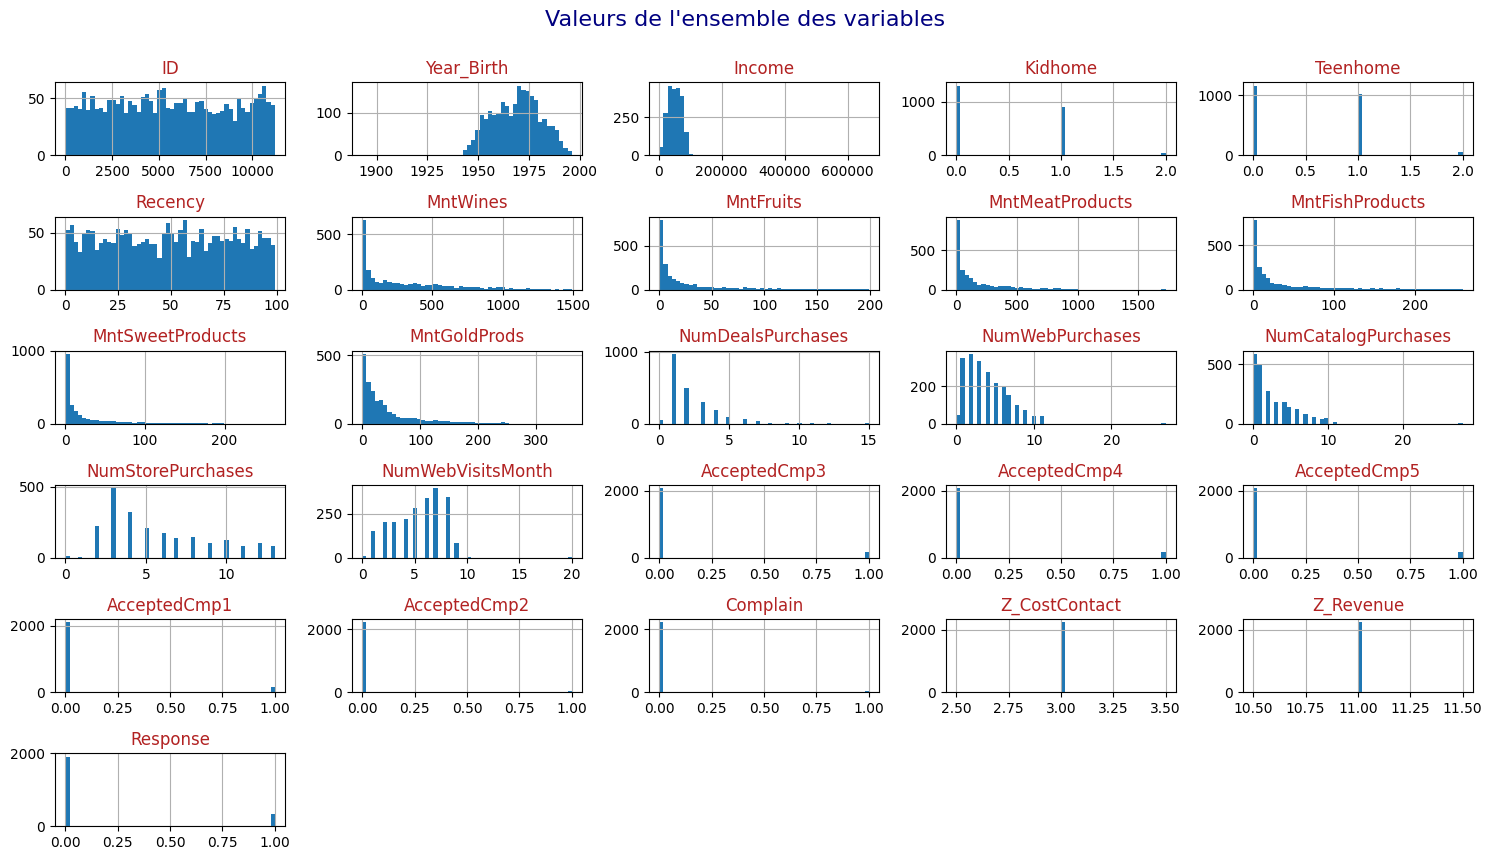

In [4]:
axes = df.hist(bins=50, figsize=(15,9))
plt.suptitle("Valeurs de l'ensemble des variables", fontsize=16, color="navy")
for ax in axes.ravel():
    ax.set_title(ax.get_title(), color='firebrick')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [5]:
df.dropna(inplace=True)
print(df.shape)

(2216, 29)


## Cleaning & Outliers

String to categorical

In [6]:
education_map = {
    '2n Cycle': 1,
    'Basic': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}
marital_map = {
    'Single': 1,
    'Divorced': 1,
    'Widow': 1,
    'Together': 2,
    'Married': 2,
    'Alone': 1,
    'Absurd': 1,
    'YOLO': 1
}
df['Education'] = df['Education'].map(education_map)
df['Marital_Status'] = df['Marital_Status'].map(marital_map)
df.shape

(2216, 29)

String(date) to int

In [7]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_For_Days'] = (reference_date - df['Dt_Customer']).dt.days
df.drop(columns='Dt_Customer', inplace=True)
df.shape

(2216, 29)

In [8]:
df = df[
    (df['Year_Birth'] > 1930) &
    (df['Income'] < 140000) &
    (df['MntMeatProducts'] < 1250) &
    (df['MntGoldProds'] < 300) &
    (df['MntSweetProducts'] < 300) &
    (df['NumWebPurchases'] < 15) &
    (df['NumCatalogPurchases'] < 15) &
    (df['NumWebVisitsMonth'] < 15)
]
df = df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'])
df.shape

(2195, 26)

In [9]:
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(df.select_dtypes(include=[np.number]))
df['Outlier_IForest'] = outlier_pred
print(df['Outlier_IForest'].value_counts())
df = df[df['Outlier_IForest'] == 1].drop(columns='Outlier_IForest')
df.shape

 1    2085
-1     110
Name: Outlier_IForest, dtype: int64


(2085, 26)

- Features division

In [10]:
extract_x_continuous = df[['Year_Birth', 'Income', 'Recency', 'MntWines',
'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
'NumCatalogPurchases', 'NumStorePurchases',
'NumWebVisitsMonth', 'Customer_For_Days', 'MntFruits',
'MntMeatProducts',
'MntFishProducts',
'MntSweetProducts']]
extract_x_continuous.shape

(2085, 15)

? Kidhome & Teenhome sont des variables catégoriels ou Continues ?

In [11]:
extract_x_cat = df[['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 
'AcceptedCmp2', 'Complain', 'Response']]
extract_x_cat.shape

(2085, 11)

## Feature engenering

### Continuous features

Faire une corrélation de Pearson puis faire un CAH pour faire du feature engenering

In [12]:
df_num = pd.DataFrame(extract_x_continuous)
df_num['Age'] = 2015 - df_num['Year_Birth']
df_num.drop(columns='Year_Birth', inplace=True)

# df_num['Spending']=df_num['MntWines']+df_num['MntFruits']+df_num['MntMeatProducts']+df_num['MntFishProducts']+df_num['MntSweetProducts']+df_num['MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 
                'NumStorePurchases', 'NumDealsPurchases']
df_num['Total_Purchases'] = df_num[purchase_cols].sum(axis=1)

df_num['MntFoodTotal'] = df_num[['MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1)
df_num.drop(columns=['MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts'], inplace=True)

df_num.shape

(2085, 13)

In [13]:
print('Before F.E : ', extract_x_continuous.shape[1])
print('After F.E : ', df_num.shape[1])

Before F.E :  16
After F.E :  13


### Categorical features

In [14]:
print('Before F.E : ', extract_x_cat.shape[1])
df_cat = pd.DataFrame(extract_x_cat)
df_cat['Children']=df_cat['Kidhome']+df_cat['Teenhome']

print('After F.E : ', df_cat.shape[1])

Before F.E :  11
After F.E :  12


## STANDARDISER

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_num.columns, index=df_num.index)

## COUDE

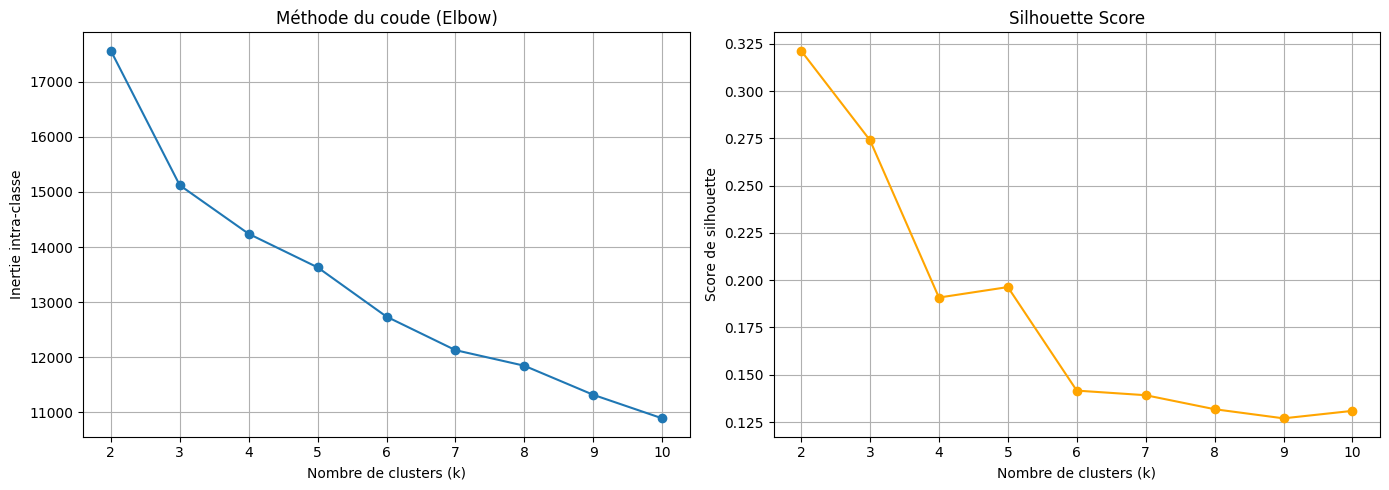

In [16]:
inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled_df)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled_df, labels))

# Affichage combiné
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
ax[0].plot(k_range, inertias, marker='o')
ax[0].set_title("Méthode du coude (Elbow)")
ax[0].set_xlabel("Nombre de clusters (k)")
ax[0].set_ylabel("Inertie intra-classe")
ax[0].grid(True)

# Silhouette
ax[1].plot(k_range, silhouettes, marker='o', color='orange')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Nombre de clusters (k)")
ax[1].set_ylabel("Score de silhouette")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled_df)

## PCA

Si dataset lourd, on peut faire chuter le nombre de variable mais plus dur à interpreter

In [18]:
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(X_scaled_df)
print('Nombre de composantes conservées :', pca.n_components_)

Nombre de composantes conservées : 9


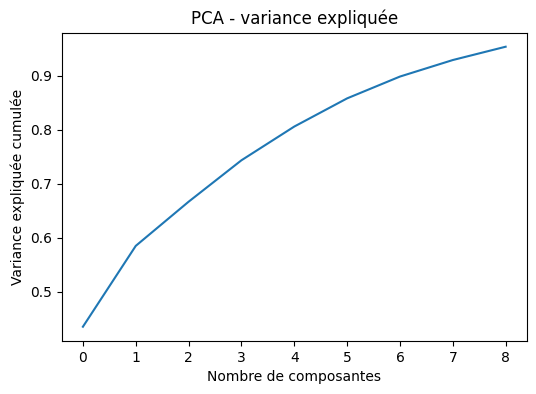

In [19]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA - variance expliquée')
plt.show()

On peut aussi plot notre dataset en nuage de points et analyser les axes 

Silhouette Score (k=3) : 0.274


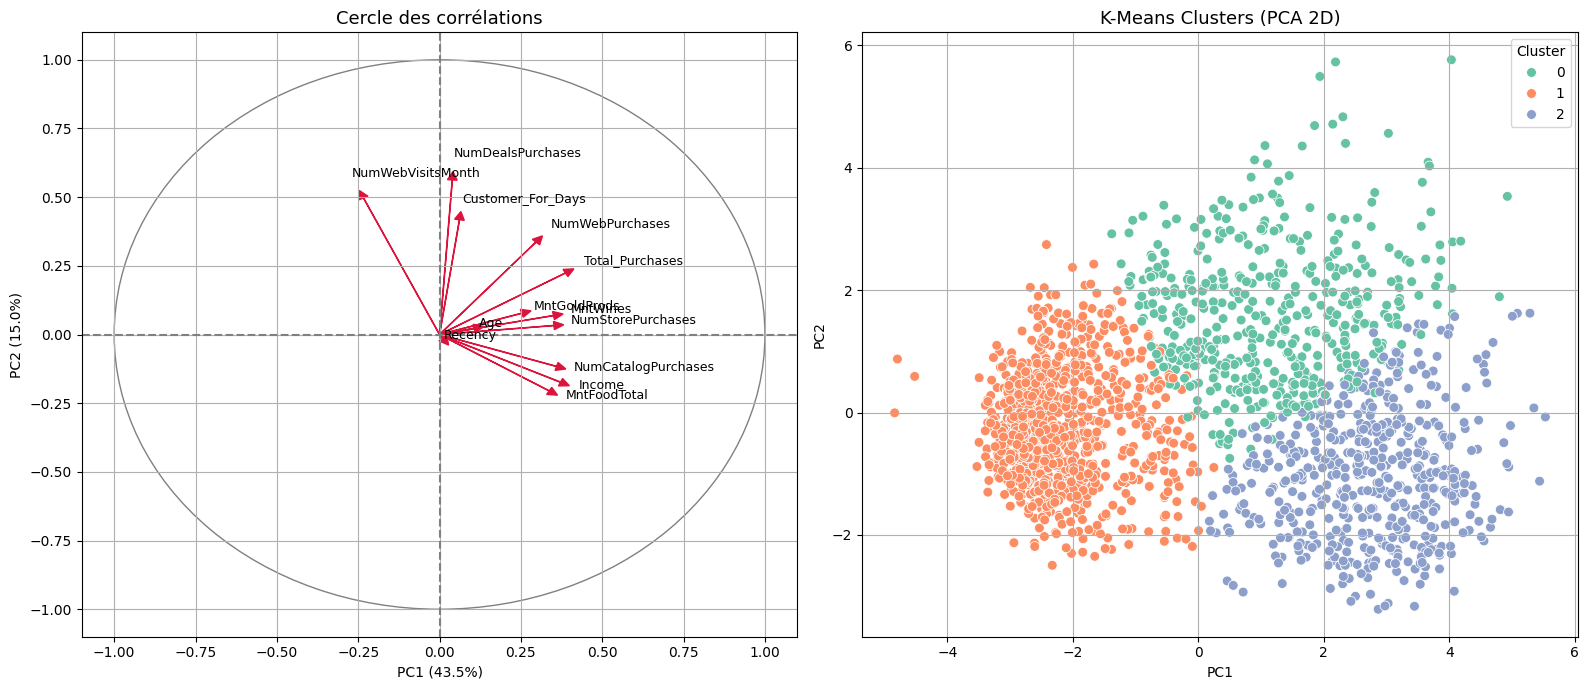

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)
pc1 = pca.components_[0]
pc2 = pca.components_[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

circle = plt.Circle((0, 0), 1, color='gray', fill=False)
ax1.add_artist(circle)

for i in range(len(X_scaled_df.columns)):
    x, y = pc1[i], pc2[i]
    ax1.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='crimson', ec='crimson')
    ax1.text(x * 1.15, y * 1.15, X_scaled_df.columns[i], fontsize=9)

ax1.axhline(0, color='grey', linestyle='--')
ax1.axvline(0, color='grey', linestyle='--')
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax1.set_title("Cercle des corrélations", fontsize=13)
ax1.grid(True)

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels_kmeans,
    palette='Set2',
    s=50,
    ax=ax2
)
ax2.set_title("K-Means Clusters (PCA 2D)", fontsize=13)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend(title="Cluster")
ax2.grid(True)

silhouette_scorer = silhouette_score(X_scaled_df, labels_kmeans)

print(f"Silhouette Score (k=3) : {silhouette_scorer:.3f}")


plt.tight_layout()
plt.show()


In [21]:
loadings = pd.DataFrame(
    data=pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_scaled_df.columns
)

for i in range(pca.n_components_):
    print(f"\n🔍 Variables les plus influentes dans PC{i+1}")
    display(loadings[f"PC{i+1}"].sort_values(key=np.abs, ascending=False))




🔍 Variables les plus influentes dans PC1


Total_Purchases        0.386982
Income                 0.371693
NumCatalogPurchases    0.359609
NumStorePurchases      0.351559
MntWines               0.350177
MntFoodTotal           0.336976
NumWebPurchases        0.296411
MntGoldProds           0.252608
NumWebVisitsMonth     -0.233751
Age                    0.106345
Customer_For_Days      0.061172
NumDealsPurchases      0.039182
Recency                0.010195
Name: PC1, dtype: float64


🔍 Variables les plus influentes dans PC2


NumDealsPurchases      0.562739
NumWebVisitsMonth      0.497064
Customer_For_Days      0.417823
NumWebPurchases        0.336587
Total_Purchases        0.223966
MntFoodTotal          -0.205107
Income                -0.173564
NumCatalogPurchases   -0.116117
MntGoldProds           0.077425
MntWines               0.069047
NumStorePurchases      0.032772
Age                    0.022690
Recency               -0.014044
Name: PC2, dtype: float64

In [22]:
df['Cluster_KMeans'] = labels_kmeans
df['Age'] = 2015 - df['Year_Birth']
df['Cluster_KMeans'] = df['Cluster_KMeans'].astype(str)

In [23]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For_Days,Cluster_KMeans,Age
0,1957,3,1,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,663,2,58
1,1954,3,1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,113,1,61
2,1965,3,2,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,312,2,50
3,1984,3,2,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,139,1,31
4,1981,5,2,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,161,0,34


In [24]:
df_clusters_0 = df[df['Cluster_KMeans'] == '0']
df_clusters_1 = df[df['Cluster_KMeans'] == '1']
df_clusters_2 = df[df['Cluster_KMeans'] == '2']


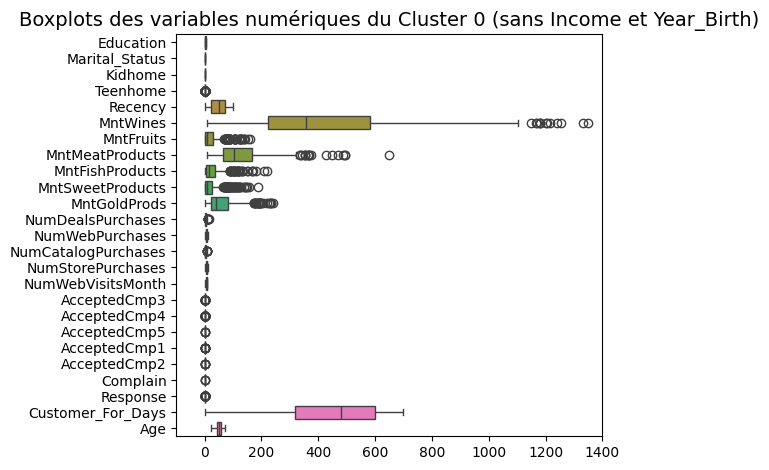

In [25]:
cols_to_plot_0 = df_clusters_0.select_dtypes(include='number').drop(columns=['Year_Birth', 'Income'])

# Boxplot horizontal
sns.boxplot(data=cols_to_plot_0, orient='h')
plt.title("Boxplots des variables numériques du Cluster 0 (sans Income et Year_Birth)", fontsize=14)
plt.xlim(-100, 1400)
plt.tight_layout()
plt.show()


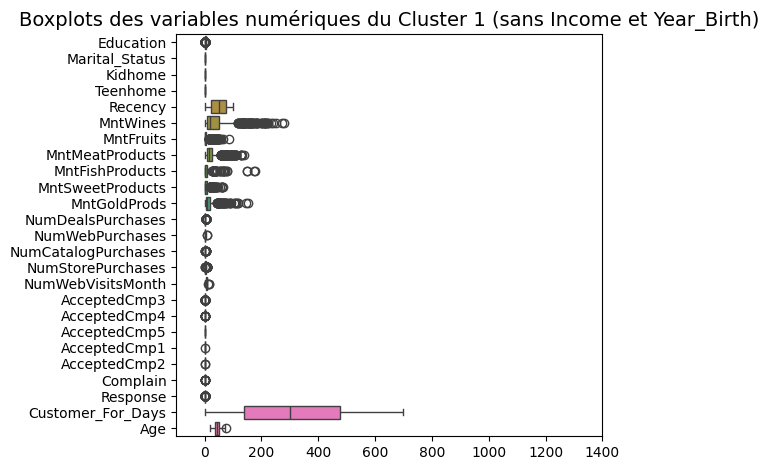

In [26]:
cols_to_plot_1 = df_clusters_1.select_dtypes(include='number').drop(columns=['Year_Birth', 'Income'])

# Boxplot horizontal
sns.boxplot(data=cols_to_plot_1, orient='h')
plt.title("Boxplots des variables numériques du Cluster 1 (sans Income et Year_Birth)", fontsize=14)

# Forcer l’axe x à une échelle commune
plt.xlim(-100, 1400)

plt.tight_layout()
plt.show()


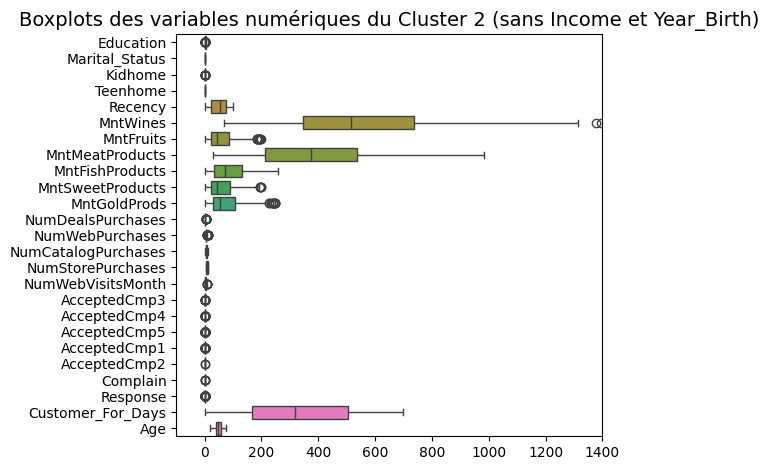

In [27]:
cols_to_plot = df_clusters_2.select_dtypes(include='number').drop(columns=['Year_Birth', 'Income'])

# Boxplot horizontal
sns.boxplot(data=cols_to_plot, orient='h')
plt.title("Boxplots des variables numériques du Cluster 2 (sans Income et Year_Birth)", fontsize=14)

# Forcer l’axe x à une échelle commune
plt.xlim(-100, 1400)

plt.tight_layout()
plt.show()


/tmp/ipykernel_10560/1578401382.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster_KMeans', y='Income', palette='Set2')


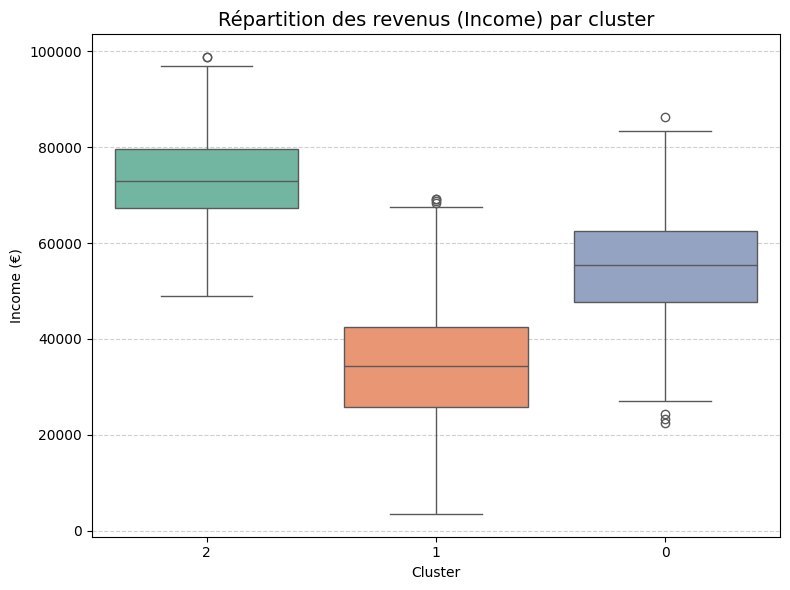

In [28]:
df['Cluster_KMeans'] = df['Cluster_KMeans'].astype(str)

# Boxplot vertical : Income par cluster
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Cluster_KMeans', y='Income', palette='Set2')
plt.title("Répartition des revenus (Income) par cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Income (€)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [29]:
# Liste des variables numériques (tu peux filtrer certaines si besoin)
numerical_cols = df.select_dtypes(include='number').columns.drop(['Year_Birth'])

# Regrouper par cluster et appliquer les fonctions statistiques
summary = df.groupby('Cluster_KMeans')[numerical_cols].agg(['mean', 'median', 'min', 'max'])

# Aplatir les colonnes multi-index
summary.columns = ['_'.join(col).capitalize() for col in summary.columns]
summary.reset_index(inplace=True)

# Affichage
pd.set_option('display.max_columns', None)
display(summary)


,Cluster_KMeans,Education_mean,Education_median,Education_min,Education_max,Marital_status_mean,Marital_status_median,Marital_status_min,Marital_status_max,Income_mean,Income_median,Income_min,Income_max,Kidhome_mean,Kidhome_median,Kidhome_min,Kidhome_max,Teenhome_mean,Teenhome_median,Teenhome_min,Teenhome_max,Recency_mean,Recency_median,Recency_min,Recency_max,Mntwines_mean,Mntwines_median,Mntwines_min,Mntwines_max,Mntfruits_mean,Mntfruits_median,Mntfruits_min,Mntfruits_max,Mntmeatproducts_mean,Mntmeatproducts_median,Mntmeatproducts_min,Mntmeatproducts_max,Mntfishproducts_mean,Mntfishproducts_median,Mntfishproducts_min,Mntfishproducts_max,Mntsweetproducts_mean,Mntsweetproducts_median,Mntsweetproducts_min,Mntsweetproducts_max,Mntgoldprods_mean,Mntgoldprods_median,Mntgoldprods_min,Mntgoldprods_max,Numdealspurchases_mean,Numdealspurchases_median,Numdealspurchases_min,Numdealspurchases_max,Numwebpurchases_mean,Numwebpurchases_median,Numwebpurchases_min,Numwebpurchases_max,Numcatalogpurchases_mean,Numcatalogpurchases_median,Numcatalogpurchases_min,Numcatalogpurchases_max,Numstorepurchases_mean,Numstorepurchases_median,Numstorepurchases_min,Numstorepurchases_max,Numwebvisitsmonth_mean,Numwebvisitsmonth_median,Numwebvisitsmonth_min,Numwebvisitsmonth_max,Acceptedcmp3_mean,Acceptedcmp3_median,Acceptedcmp3_min,Acceptedcmp3_max,Acceptedcmp4_mean,Acceptedcmp4_median,Acceptedcmp4_min,Acceptedcmp4_max,Acceptedcmp5_mean,Acceptedcmp5_median,Acceptedcmp5_min,Acceptedcmp5_max,Acceptedcmp1_mean,Acceptedcmp1_median,Acceptedcmp1_min,Acceptedcmp1_max,Acceptedcmp2_mean,Acceptedcmp2_median,Acceptedcmp2_min,Acceptedcmp2_max,Complain_mean,Complain_median,Complain_min,Complain_max,Response_mean,Response_median,Response_min,Response_max,Customer_for_days_mean,Customer_for_days_median,Customer_for_days_min,Customer_for_days_max,Age_mean,Age_median,Age_min,Age_max
0,0,3.587209,3.0,1,5,1.662791,2.0,1,2,54863.833333,55390.5,22507.0,86358.0,0.354651,0.0,0,2,0.872093,1.0,0,2,48.428295,49.0,0,99,431.389535,358.0,7,1349,22.114341,10.0,0,161,126.819767,103.5,10,650,27.284884,14.0,0,220,22.120155,10.0,0,188,56.331395,39.5,0,242,4.269380,4.0,1,15,6.583333,6.0,1,11,2.699612,2.0,0,10,7.443798,7.0,3,13,6.445736,7.0,2,10,0.067829,0.0,0,1,0.131783,0.0,0,1,0.007752,0.0,0,1,0.023256,0.0,0,1,0.009690,0.0,0,1,0.005814,0.0,0,1,0.141473,0.0,0,1,445.372093,479.0,0,699,49.517442,49.0,23,72
1,1,3.258776,3.0,1,5,1.645938,2.0,1,2,34605.051153,34412.0,3502.0,69139.0,0.760281,1.0,0,2,0.451354,0.0,0,2,49.045135,49.0,0,99,38.701103,20.0,0,279,5.208626,2.0,0,87,21.848546,14.0,0,137,7.855567,3.0,0,179,5.359077,2.0,0,66,14.983952,10.0,0,153,1.886660,2.0,0,5,2.046138,2.0,0,8,0.545637,0.0,0,5,3.233701,3.0,0,8,6.315948,7.0,1,14,0.070211,0.0,0,1,0.012036,0.0,0,1,0.000000,0.0,0,0,0.001003,0.0,0,1,0.002006,0.0,0,1,0.011033,0.0,0,1,0.085256,0.0,0,1,314.494483,301.0,0,697,43.461384,42.0,19,75
2,2,3.466783,3.0,1,5,1.645105,2.0,1,2,73359.181818,72923.0,48948.0,98777.0,0.034965,0.0,0,2,0.323427,0.0,0,2,49.709790,52.5,0,99,557.479021,514.5,68,1478,59.547203,45.0,0,197,390.849650,374.0,29,984,87.977273,72.0,0,259,60.493007,45.0,0,198,73.225524,54.0,0,249,1.375874,1.0,0,6,5.027972,5.0,1,11,5.524476,5.0,1,11,8.517483,8.0,4,13,2.832168,3.0,0,8,0.040210,0.0,0,1,0.064685,0.0,0,1,0.136364,0.0,0,1,0.096154,0.0,0,1,0.003497,0.0,0,1,0.006993,0.0,0,1,0.159091,0.0,0,1,335.790210,317.0,1,697,47.931818,48.0,20,74


In [30]:
champs = [
    'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'Customer_For_Days', 'Age'
]

# Dictionnaire qui contiendra un tableau par champ
tables_par_champ = {}

# Création d’un tableau par champ avec statistiques étendues
for champ in champs:
    tableau = df.groupby('Cluster_KMeans')[champ].agg(
        Moyenne='mean',
        Min='min',
        Q1=lambda x: x.quantile(0.25),
        Médiane='median',
        Q3=lambda x: x.quantile(0.75),
        Max='max'
    ).reset_index()
    
    tables_par_champ[champ] = tableau


In [31]:
for champ, tableau in tables_par_champ.items():
    print(f"\n📊 Statistiques par cluster pour : {champ}")
    display(tableau)



📊 Statistiques par cluster pour : Income


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,54863.833333,22507.0,47733.0,55390.5,62475.25,86358.0
1,1,34605.051153,3502.0,25851.0,34412.0,42554.00,69139.0
2,2,73359.181818,48948.0,67286.5,72923.0,79700.25,98777.0



📊 Statistiques par cluster pour : Recency


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,48.428295,0,24.0,49.0,70.25,99
1,1,49.045135,0,24.0,49.0,75.00,99
2,2,49.709790,0,24.0,52.5,74.00,99



📊 Statistiques par cluster pour : MntWines


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,431.389535,7,223.75,358.0,582.5,1349
1,1,38.701103,0,8.00,20.0,51.0,279
2,2,557.479021,68,347.00,514.5,738.0,1478



📊 Statistiques par cluster pour : MntFruits


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,22.114341,0,3.0,10.0,28.0,161
1,1,5.208626,0,0.0,2.0,6.0,87
2,2,59.547203,0,23.0,45.0,86.0,197



📊 Statistiques par cluster pour : MntMeatProducts


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,126.819767,10,64.0,103.5,168.25,650
1,1,21.848546,0,7.0,14.0,26.00,137
2,2,390.849650,29,212.0,374.0,535.25,984



📊 Statistiques par cluster pour : MntFishProducts


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,27.284884,0,4.0,14.0,38.00,220
1,1,7.855567,0,0.0,3.0,10.00,179
2,2,87.977273,0,34.0,72.0,133.25,259



📊 Statistiques par cluster pour : MntSweetProducts


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,22.120155,0,3.0,10.0,27.0,188
1,1,5.359077,0,0.0,2.0,7.0,66
2,2,60.493007,0,23.0,45.0,91.0,198



📊 Statistiques par cluster pour : MntGoldProds


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,56.331395,0,21.0,39.5,82.0,242
1,1,14.983952,0,4.0,10.0,20.0,153
2,2,73.225524,0,29.0,54.0,107.0,249



📊 Statistiques par cluster pour : NumDealsPurchases


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,4.269380,1,3.0,4.0,6.0,15
1,1,1.886660,0,1.0,2.0,2.0,5
2,2,1.375874,0,1.0,1.0,2.0,6



📊 Statistiques par cluster pour : NumWebPurchases


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,6.583333,1,5.0,6.0,8.0,11
1,1,2.046138,0,1.0,2.0,3.0,8
2,2,5.027972,1,4.0,5.0,6.0,11



📊 Statistiques par cluster pour : NumCatalogPurchases


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,2.699612,0,1.0,2.0,4.0,10
1,1,0.545637,0,0.0,0.0,1.0,5
2,2,5.524476,1,4.0,5.0,7.0,11



📊 Statistiques par cluster pour : NumStorePurchases


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,7.443798,3,5.0,7.0,9.0,13
1,1,3.233701,0,3.0,3.0,4.0,8
2,2,8.517483,4,6.0,8.0,11.0,13



📊 Statistiques par cluster pour : NumWebVisitsMonth


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,6.445736,2,5.0,7.0,8.0,10
1,1,6.315948,1,5.0,7.0,8.0,14
2,2,2.832168,0,2.0,3.0,4.0,8



📊 Statistiques par cluster pour : Customer_For_Days


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,445.372093,0,317.25,479.0,601.00,699
1,1,314.494483,0,138.00,301.0,475.00,697
2,2,335.790210,1,165.25,317.0,505.25,697



📊 Statistiques par cluster pour : Age


,Cluster_KMeans,Moyenne,Min,Q1,Médiane,Q3,Max
0,0,49.517442,23,42.0,49.0,59.0,72
1,1,43.461384,19,36.0,42.0,50.0,75
2,2,47.931818,20,39.0,48.0,58.0,74


In [32]:
import pandas as pd

# Exemple : ton DataFrame doit contenir une colonne 'Cluster_KMeans'
# et les variables catégorielles que tu veux analyser
champs_cat = [
    'Education', 'Marital_Status', 'Kidhome', 'Teenhome',
    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
    'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'
]

# Dictionnaire contenant un tableau par champ
tables_par_champ = {}

# Création des tableaux de proportion par modalité et cluster
for champ in champs_cat:
    tableau = (
        pd.crosstab(df['Cluster_KMeans'], df[champ], normalize='index') * 100
    ).round(1)  # pour avoir des pourcentages arrondis à 1 décimale
    tables_par_champ[champ] = tableau.reset_index()



In [33]:
for champ_cat, tableau in tables_par_champ.items():
    print(f"\n📊 Proportion par cluster pour : {champ_cat}")
    display(tableau)



📊 Proportion par cluster pour : Education


Education,Cluster_KMeans,1,2,3,4,5
0,0,6.4,0.4,48.1,18.4,26.7
1,1,10.9,5.2,49.2,16.2,18.4
2,2,7.5,0.0,53.8,15.6,23.1



📊 Proportion par cluster pour : Marital_Status


Marital_Status,Cluster_KMeans,1,2
0,0,33.7,66.3
1,1,35.4,64.6
2,2,35.5,64.5



📊 Proportion par cluster pour : Kidhome


Kidhome,Cluster_KMeans,0,1,2
0,0,66.1,32.4,1.6
1,1,27.6,68.8,3.6
2,2,96.7,3.1,0.2



📊 Proportion par cluster pour : Teenhome


Teenhome,Cluster_KMeans,0,1,2
0,0,17.8,77.1,5.0
1,1,56.3,42.3,1.4
2,2,68.9,29.9,1.2



📊 Proportion par cluster pour : AcceptedCmp3


AcceptedCmp3,Cluster_KMeans,0,1
0,0,93.2,6.8
1,1,93.0,7.0
2,2,96.0,4.0



📊 Proportion par cluster pour : AcceptedCmp4


AcceptedCmp4,Cluster_KMeans,0,1
0,0,86.8,13.2
1,1,98.8,1.2
2,2,93.5,6.5



📊 Proportion par cluster pour : AcceptedCmp5


AcceptedCmp5,Cluster_KMeans,0,1
0,0,99.2,0.8
1,1,100.0,0.0
2,2,86.4,13.6



📊 Proportion par cluster pour : AcceptedCmp1


AcceptedCmp1,Cluster_KMeans,0,1
0,0,97.7,2.3
1,1,99.9,0.1
2,2,90.4,9.6



📊 Proportion par cluster pour : AcceptedCmp2


AcceptedCmp2,Cluster_KMeans,0,1
0,0,99.0,1.0
1,1,99.8,0.2
2,2,99.7,0.3



📊 Proportion par cluster pour : Complain


Complain,Cluster_KMeans,0,1
0,0,99.4,0.6
1,1,98.9,1.1
2,2,99.3,0.7



📊 Proportion par cluster pour : Response


Response,Cluster_KMeans,0,1
0,0,85.9,14.1
1,1,91.5,8.5
2,2,84.1,15.9


✅ Cluster 0
Profil : Consommateurs à revenu intermédiaire (~55k), peu de dépenses en vin ou produits gourmets, panier moyen modéré.

Enfants : 66% sans enfants.

Réponses aux campagnes : Faible taux d’acceptation.

Typologie possible : Familles classiques ou couples avec peu de réactivité marketing.

✅ Cluster 1
Profil : Faible revenu (~34k), faibles dépenses partout, très peu de fidélité client.

Enfants : Plus souvent avec des enfants (Teenhome + Kidhome élevés).

Réponses marketing : Presque aucune.

Typologie possible : Jeunes foyers avec enfants, peu de moyens, peu sensibles aux campagnes.

✅ Cluster 2
Profil : Très haut revenu (~73k), dépenses importantes sur tous les produits (vin, viande, sucrés, or).

Pas d’enfants (Kidhome 97% à 0, Teenhome 69% à 0).

Réponse marketing plus forte sur AcceptedCmp1, 3, 5.

Typologie possible : Célibataires/seniors ou couples sans enfants, très bon pouvoir d’achat et très engagés.

